# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

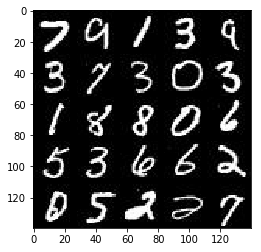

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

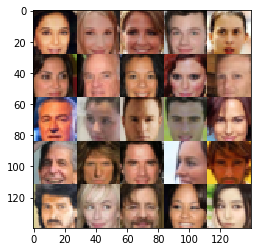

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3  --> 16,16,64
        conv1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        # Leaky ReLU
        conv1 = tf.maximum(alpha * conv1, conv1) 
 
        # Second layer is 8x8x128
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer conv2
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        # Leaky ReLU
        conv2 = tf.maximum(alpha * conv2, conv2) 
        
 
        # Third layer is 4x4x256
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer conv3
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        # Leaky ReLU
        conv3 = tf.maximum(alpha * conv3, conv3) 
        
        # Flatten it
        flat = tf.reshape(conv3, shape=[-1, 4 * 4 * 256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
              
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer, 7x7x512
        conv1 = tf.layers.dense(z, 7*7*512, activation=None)
        #reshape the layer x1 to start the convolutional stack
        conv1 = tf.reshape(conv1, shape=[-1, 7, 7, 512])
        # add batch normalization to the layer conv1
        conv1 = tf.layers.batch_normalization(conv1, training = is_train)
        # Leaky ReLU
        conv1 = tf.maximum(alpha * conv1, conv1)

    
        # second transposed 2D convolution layer, 7x7x256
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides = 1, padding = 'same')
        # add batch normalization to the layer conv2
        conv2 = tf.layers.batch_normalization(conv2, training = is_train)
        # Leaky ReLU
        conv2 = tf.maximum(alpha * conv2, conv2)

        
        # third transposed 2D convolution layer, 14x14x128
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides = 2, padding = 'same')
        # add batch normalization to the layer x3
        conv3 = tf.layers.batch_normalization(conv3, training = is_train)
        # Leaky ReLU
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
   # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        # Real input images with rank 4 of n_images, image_width, image_height, and image_channels
    n_samples, image_width, image_height, image_channels = data_shape
    out_channel_dim = image_channels 
    
    #Network Inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #Model Loss    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    #Optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)  
    
    
    losses = []
    steps = 0
    print_every=10
    show_every=100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                                #rescale to pass to D
                batch_images = batch_images*2.0
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 2.7811... Generator Loss: 0.0815
Epoch 1/2... Discriminator Loss: 1.8932... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 4.1856
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 2.0606... Generator Loss: 0.2840
Epoch 1/2... Discriminator Loss: 2.2062... Generator Loss: 0.2545
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 1.7309
Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.6775


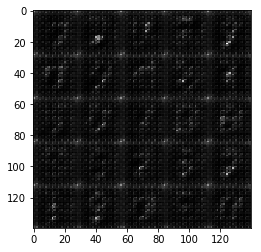

Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 1.6045... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 1.3399
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.5631


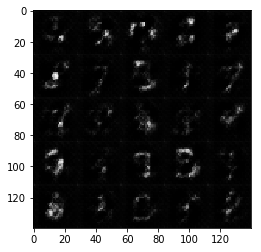

Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.8873
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.3201
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 0.8869


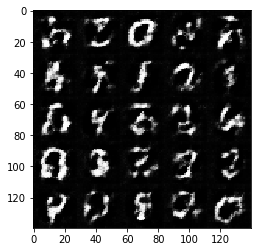

Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 1.0644


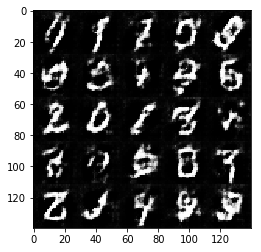

Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.4289
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 1.2029
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.7443
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.4092
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 1.8124
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.9066


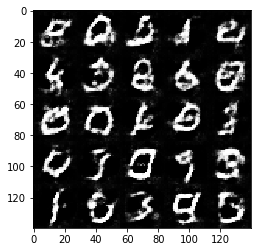

Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 1.9611
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.2473
Epoch 1/2... Discriminator Loss: 1.7694... Generator Loss: 0.2703
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.9978
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 1.6227
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.0673


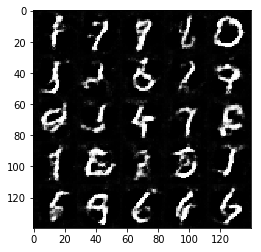

Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 0.9699
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.4171
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 0.8265


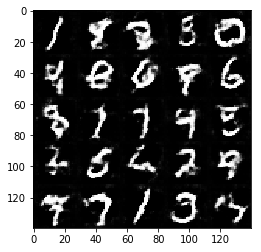

Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.1335
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.4507
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 1.5838
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.2059


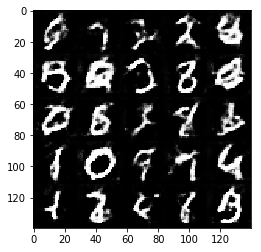

Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.4297
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 0.9631
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 0.7099


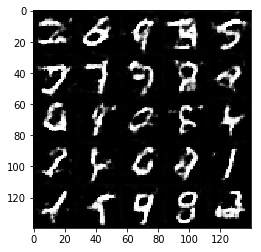

Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.7769
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.1091
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.5531


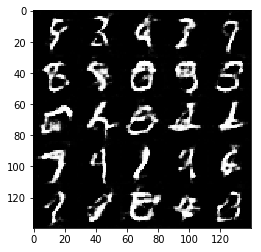

Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 0.9498
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4530
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.7613


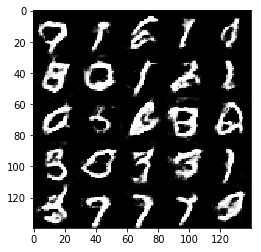

Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.5459
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 2.0015... Generator Loss: 0.1741
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 0.6929


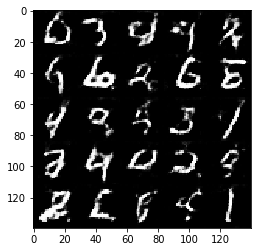

Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 0.5849... Generator Loss: 1.0791
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 2.1038
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.4361
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 0.9326


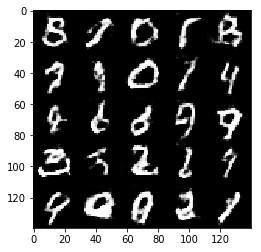

Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.5033
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.7844


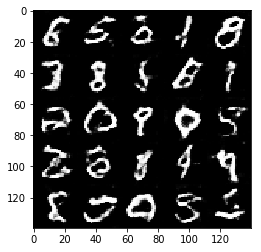

Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.5685
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.2112


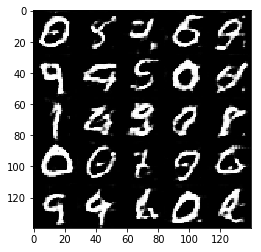

Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 0.8011... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.3973
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 2.3273
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.5111


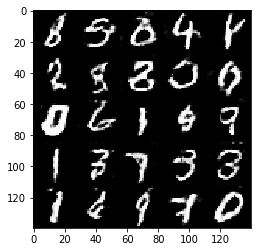

Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.6445
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.4512


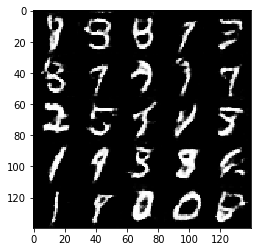

Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.3573
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 1.6752
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 3.5089
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.3455
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 0.2810


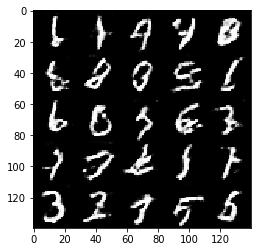

Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.2403
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 3.0363
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.1022
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.0251


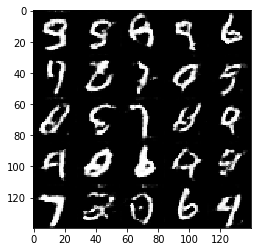

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.5432... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.5508


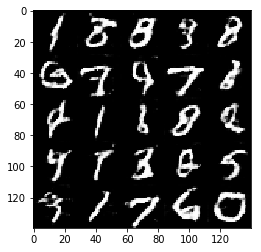

Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.4908
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 1.5230
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.4089
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.7990


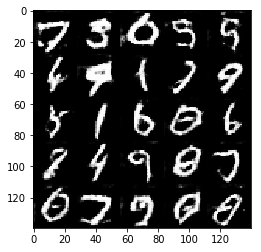

Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.6189
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.8282
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 0.9235


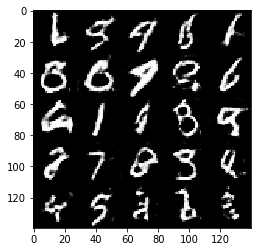

Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 0.6073... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.4940
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 1.2430
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 2.9457


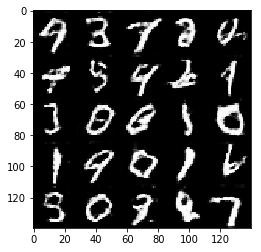

Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 2.6805
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.2105
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.4907
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 0.9999


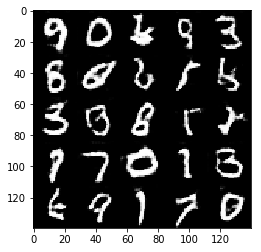

Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 0.4009... Generator Loss: 1.8476
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.5228
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 0.6155... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 0.4574


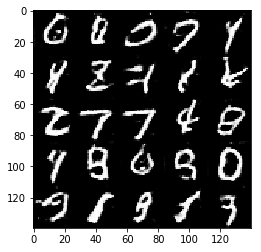

Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 0.5642... Generator Loss: 1.2358
Epoch 2/2... Discriminator Loss: 1.9569... Generator Loss: 0.2054
Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 1.6955
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.3824
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 1.3907
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 3.5554
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 0.5127... Generator Loss: 1.3084


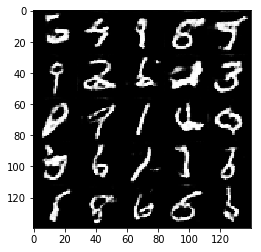

Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 0.5334... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.0225
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.6175... Generator Loss: 2.3989


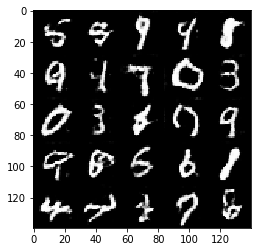

Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.5986... Generator Loss: 3.7653
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 2.6149... Generator Loss: 5.1732
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 1.9820


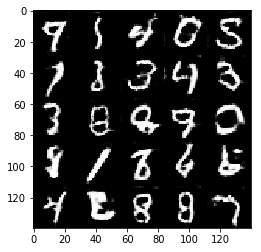

Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 0.4497... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 1.8972
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 0.8709


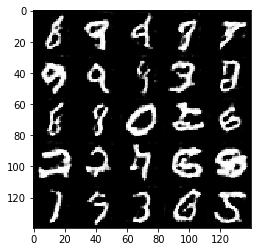

Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.0267
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 0.9560
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.4019


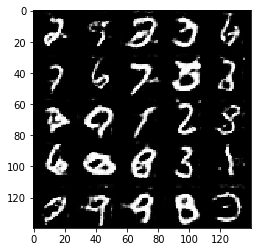

Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.4332
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 2.0012... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 0.6280... Generator Loss: 1.2584
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 4.1825


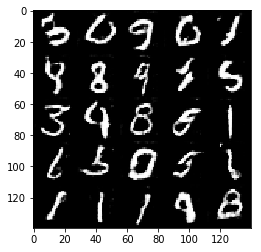

Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.2165
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 0.7633
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.2125
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 3.8190
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 1.7062
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 0.8619


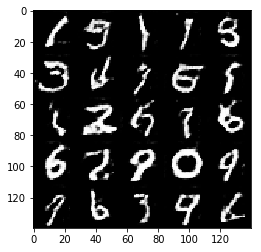

Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 1.5292... Generator Loss: 0.4148
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 0.5944... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.4275... Generator Loss: 1.4102
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.0015


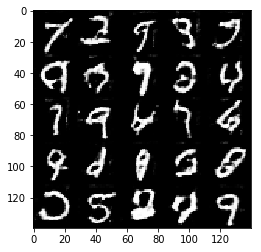

Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 1.2847
Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 0.2769... Generator Loss: 1.8825
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.2643
Epoch 2/2... Discriminator Loss: 2.2254... Generator Loss: 0.1706
Epoch 2/2... Discriminator Loss: 2.0998... Generator Loss: 0.2150
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 1.6441
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.1975


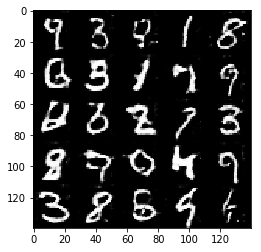

Epoch 2/2... Discriminator Loss: 2.2713... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 3.4467
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.5859
Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 3.3454
Epoch 2/2... Discriminator Loss: 0.5487... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 1.6134
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.1271
Epoch 2/2... Discriminator Loss: 0.4346... Generator Loss: 2.9335
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.1414


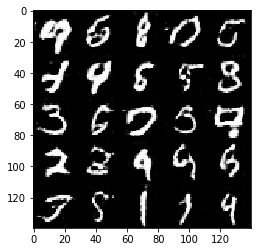

Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 3.6602
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 1.4824
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.0058
Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 1.2148


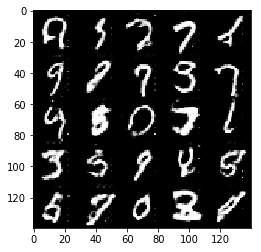

Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 1.2864
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.3670
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 1.3868
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.1085
Epoch 2/2... Discriminator Loss: 1.7381... Generator Loss: 0.3133
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 1.3693
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 1.6880


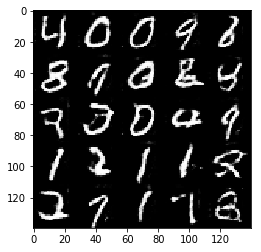

Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 0.7653


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2210... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 4.5439
Epoch 1/1... Discriminator Loss: 2.9116... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 2.6701... Generator Loss: 0.2947
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 3.0910


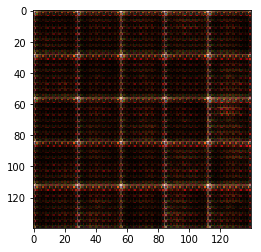

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 2.1558
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 2.0410
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.3867


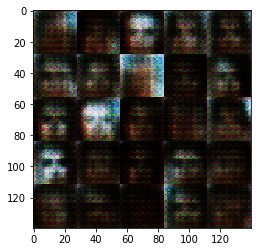

Epoch 1/1... Discriminator Loss: 2.0583... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.9287


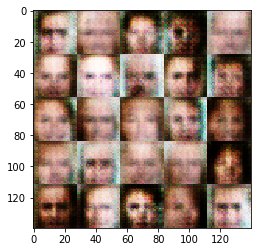

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.6102


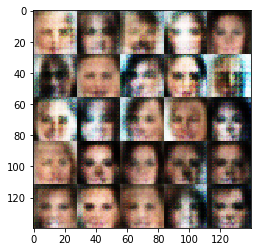

Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7380


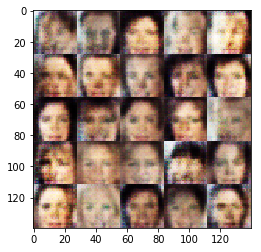

Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.5964


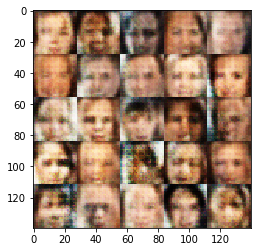

Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7913


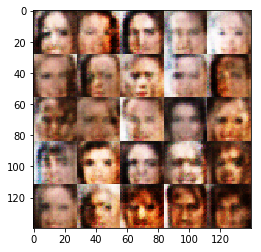

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5656


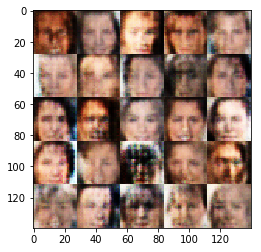

Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9075


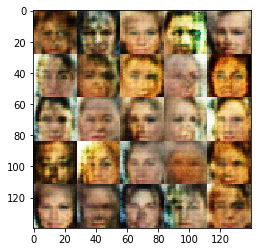

Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5527


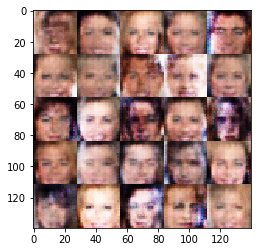

Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6791


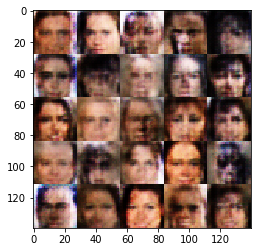

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.6372


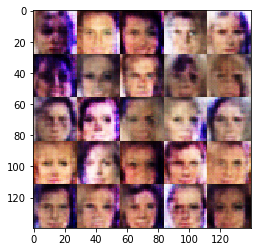

Epoch 1/1... Discriminator Loss: 1.6961... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7173


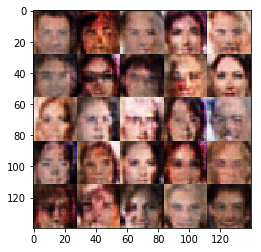

Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6749


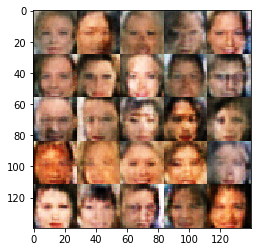

Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7978


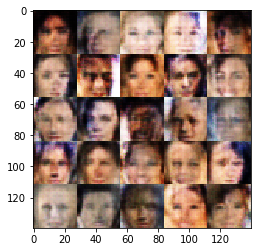

Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5465


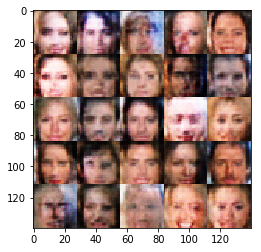

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.6757


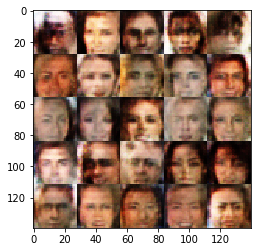

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7624


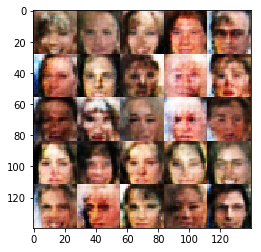

Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7947


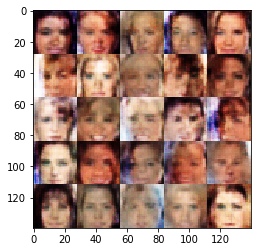

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5030


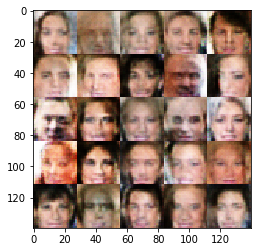

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7113


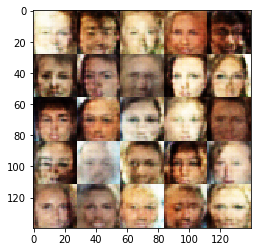

Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.4616


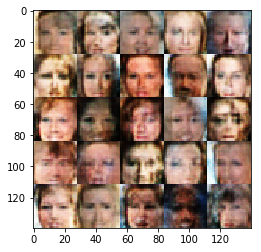

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7369


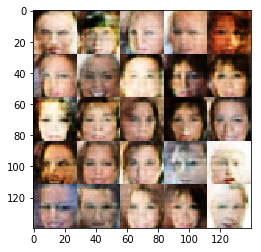

Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5019


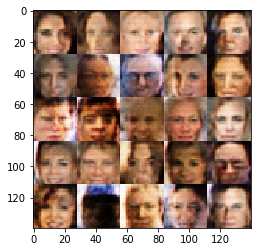

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.9098


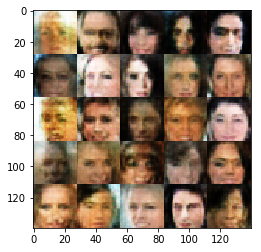

Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4822


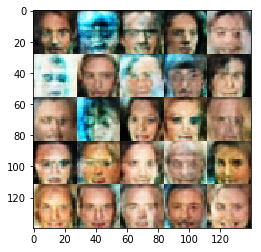

Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6100


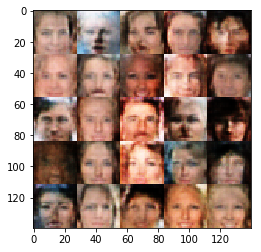

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7027


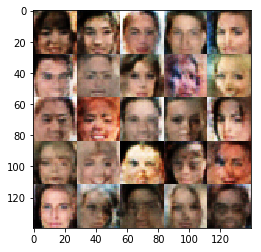

Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8984


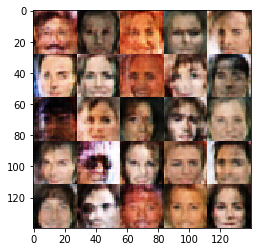

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5282


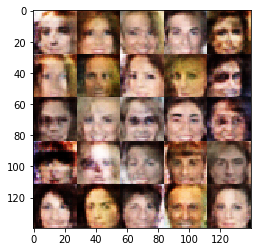

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5333


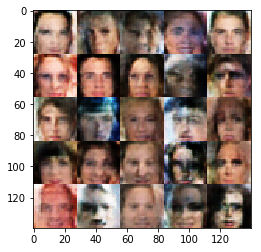

Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7577


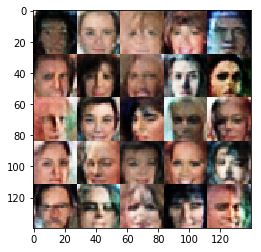

Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5256


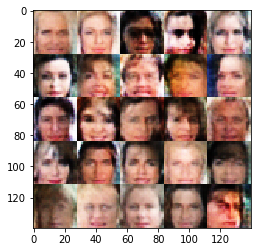

Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.9602
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6148


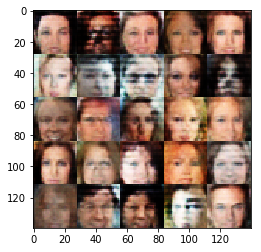

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.4632


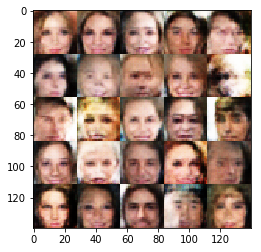

Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.7750


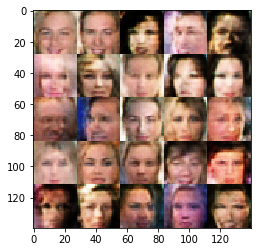

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 0.9053


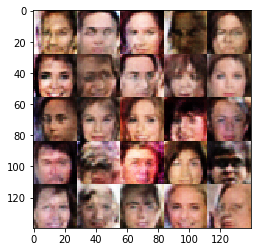

Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5586


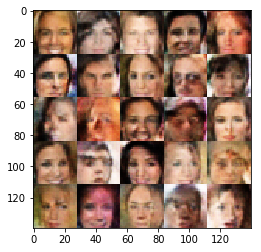

Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.3099
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.5336


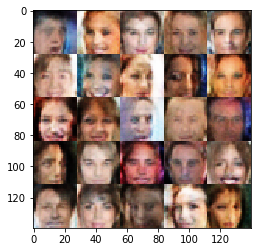

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8863


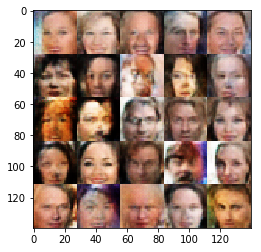

Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.3647
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4789


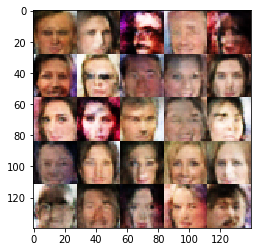

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.9076


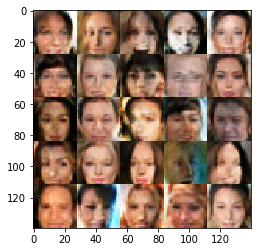

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7211


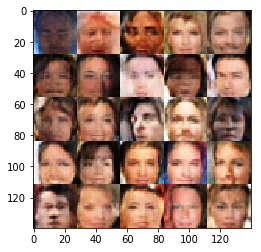

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.8489


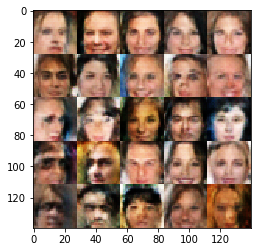

Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.3017


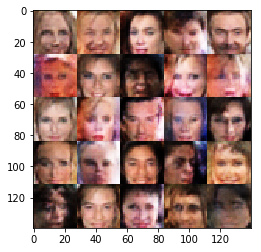

Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.7690


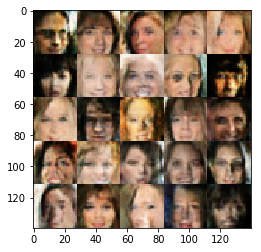

Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7207


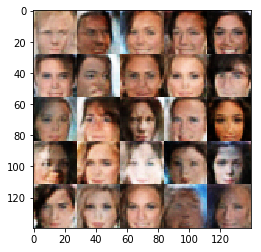

Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.5553


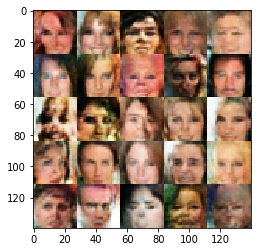

Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.8277


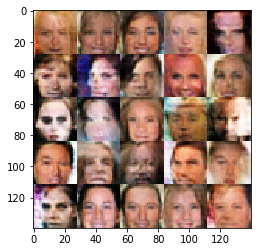

Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.5598


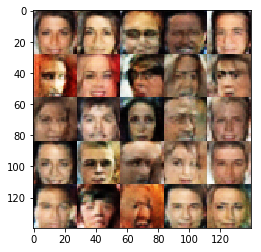

Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.7789


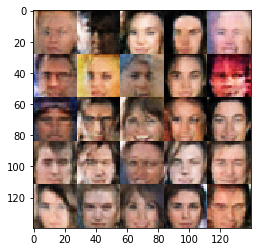

Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.2447


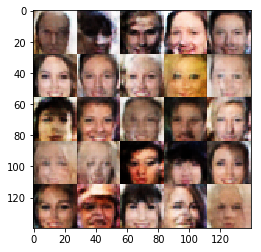

Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 0.9190


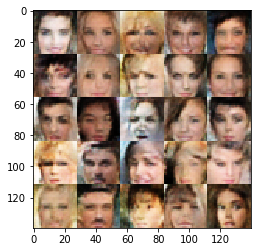

Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7691


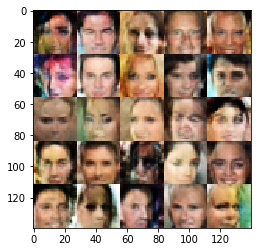

Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.9375... Generator Loss: 0.2470


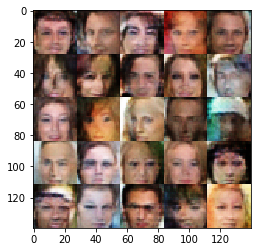

Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.5563


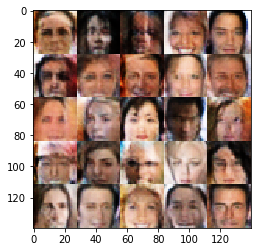

Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.7212


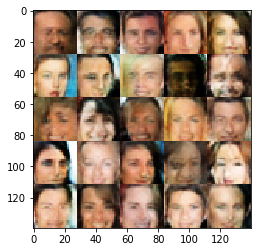

Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 2.0097... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.7014


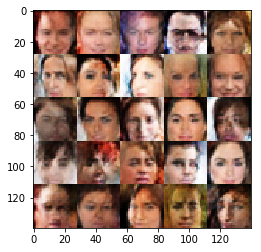

Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6184


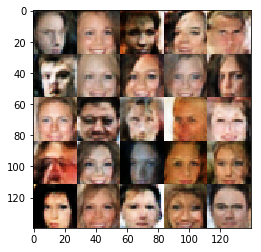

Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.9099... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.0810


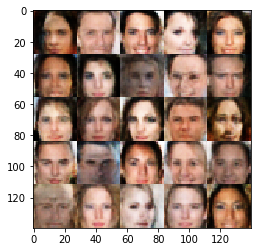

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.4164


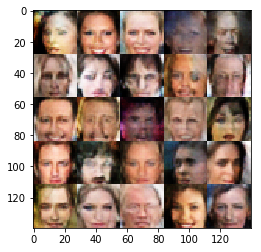

Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.5661


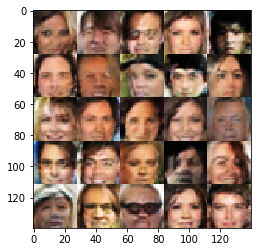

Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.3424
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.4318


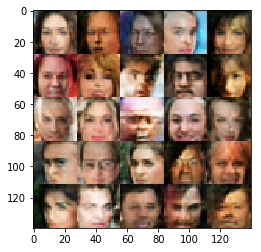

Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.8876


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.